# Plotting Running Times

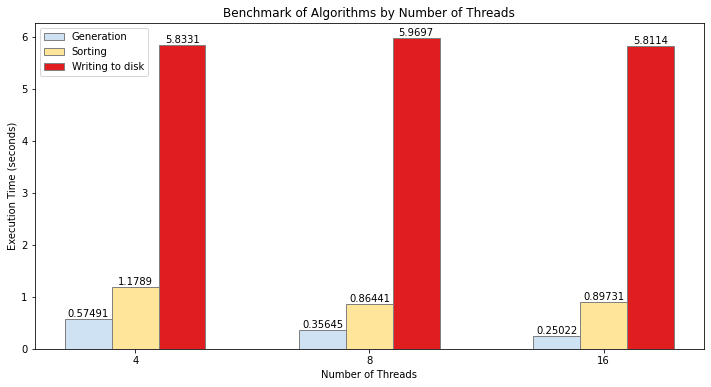

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re

generate_once = "src/benchmark/generate_once.sh"

threads = ["1", "2", "4", "8", "16"]

execution_times = {
    "Generation": [],
    "Sorting": [],
    "Writing to disk": [],
}

for knum in range(25, 30):
    for thread_num in [1, 2, 4, 8, 16]:
        try:
            result = subprocess.run([generate_once, str(knum), str(thread_num)], capture_output=True, text=True, check=True)
            print(result.stdout)
            
            # Parse execution times from the output (customize the regex according to your output)
            generation_time = float(re.search(r'Hash generation.*took ([0-9.]+)', result.stdout).group(1))
            sorting_time = float(re.search(r'Sorting hashes took ([0-9.]+)', result.stdout).group(1))
            writing_time = float(re.search(r'Writing hashes to disk took ([0-9.]+)', result.stdout).group(1))
            
            # Append times to the respective lists
            execution_times["Generation"].append(generation_time)
            execution_times["Sorting"].append(sorting_time)
            execution_times["Writing to disk"].append(writing_time)

        except subprocess.CalledProcessError as e:
            print(f"Error executing hash generation script: {e}")
            print(e.stderr)
            
# Function to create and save bar chart
def create_plot(phase):
    plt.figure(figsize=(12, 6))
    plt.bar(threads, execution_times[phase], color="#cfe2f3ff", edgecolor="grey")
    
    plt.xlabel("Number of Threads")
    plt.ylabel("Execution Time (seconds)")
    plt.title(f"{phase} Execution Time by Number of Threads")
    plt.xticks(threads)

    # Add data labels on top of bars
    for i in range(len(threads)):
        plt.text(
            i + 1,  # Adjust position for center alignment
            execution_times[phase][i] + 0.01,
            f"{execution_times[phase][i]:.5f}",
            ha="center",
            va="bottom",
        )
    
    plt.savefig(f"{phase.lower().replace(' ', '_')}_benchmark_results.svg")
    plt.close()

# Create plots for each phase
for phase in execution_times.keys():
    create_plot(phase)

# # Bar width
# bar_width = 0.2

# # X positions for the bars
# r1 = np.arange(len(threads))
# r2 = [x + bar_width for x in r1]
# r3 = [x + bar_width for x in r2]

# # Create the bar chart
# plt.figure(figsize=(12, 6))

# plt.bar(
#     r1,
#     execution_times["Generation"],
#     color="#cfe2f3ff",
#     width=bar_width,
#     edgecolor="grey",
#     label="Generation",
# )
# plt.bar(
#     r2,
#     execution_times["Sorting"],
#     color="#ffe599ff",
#     width=bar_width,
#     edgecolor="grey",
#     label="Sorting",
# )
# plt.bar(
#     r3,
#     execution_times["Writing to disk"],
#     color="#e01e20",
#     width=bar_width,
#     edgecolor="grey",
#     label="Writing to disk",
# )

# # Add labels and title
# plt.xlabel("Number of Threads")
# plt.ylabel("Execution Time (seconds)")
# plt.title("Benchmark of Algorithms by Number of Threads")
# plt.xticks([r + bar_width for r in range(len(threads))], threads)

# # Add data labels on top of bars
# for i in range(len(threads)):
#     plt.text(
#         r1[i],
#         execution_times["Generation"][i] + 0.01,
#         str(execution_times["Generation"][i]),
#         ha="center",
#         va="bottom",
#     )
#     plt.text(
#         r2[i],
#         execution_times["Sorting"][i] + 0.01,
#         str(execution_times["Sorting"][i]),
#         ha="center",
#         va="bottom",
#     )
#     plt.text(
#         r3[i],
#         execution_times["Writing to disk"][i] + 0.01,
#         str(execution_times["Writing to disk"][i]),
#         ha="center",
#         va="bottom",
#     )

# # Add legend
# plt.legend()

# # Save the plot to a file instead of showing it
# plt.savefig("benchmark_results.png")

# # Display the plot
# plt.show()


# Plotting System Stats

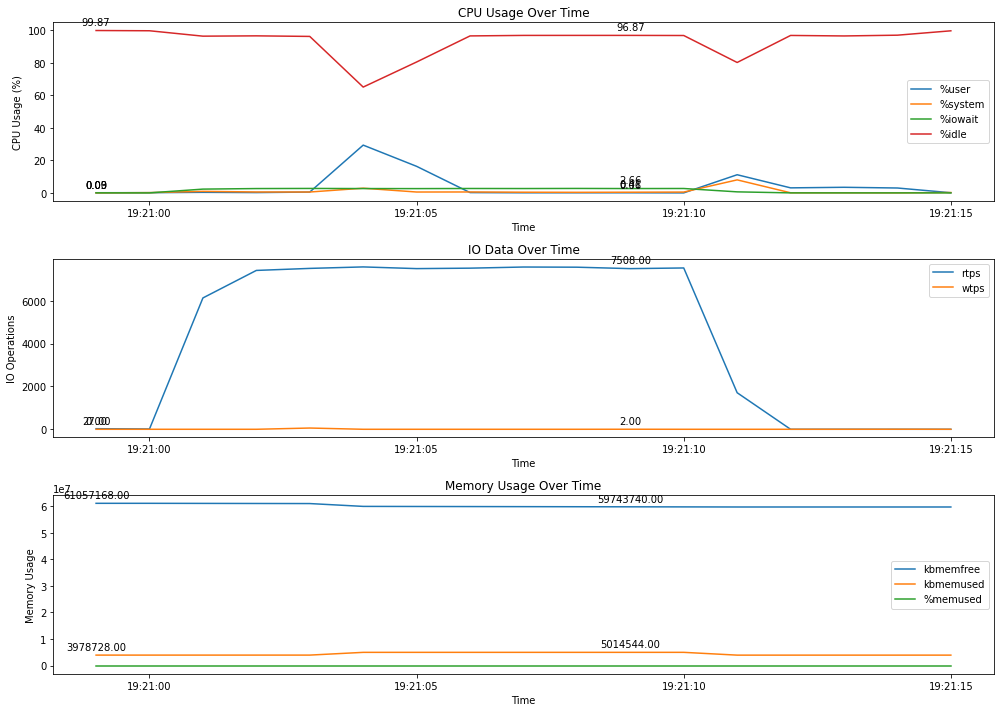

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt


def parse_cpu_data(file_path):
    cpu_data = []
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines[3:]:
            parts = line.split()
            if len(parts) == 8:  # Ensure there are 9 columns
                Time, cpu, user, nice, system, iowait, steal, idle = parts
                cpu_data.append(
                    [
                        Time,
                        cpu,
                        float(user),
                        float(nice),
                        float(system),
                        float(iowait),
                        float(steal),
                        float(idle),
                    ]
                )
    cpu_df = pd.DataFrame(
        cpu_data,
        columns=[
            "Time",
            "CPU",
            "%user",
            "%nice",
            "%system",
            "%iowait",
            "%steal",
            "%idle",
        ],
    )
    return cpu_df


def parse_io_data(file_path):
    io_data = []
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines[3:]:  # Skipping the first 3 lines (header information)
            parts = line.split()
            if len(parts) == 8:  # Ensure there are 8 columns
                Time, tps, rtps, wtps, dtps, bread, bwrtn, bdscd = parts
                io_data.append(
                    [
                        Time,
                        float(tps),
                        float(rtps),
                        float(wtps),
                        float(dtps),
                        float(bread),
                        float(bwrtn),
                        float(bdscd),
                    ]
                )
    io_df = pd.DataFrame(
        io_data,
        columns=[
            "Time",
            "tps",
            "rtps",
            "wtps",
            "dtps",
            "bread/s",
            "bwrtn/s",
            "bdscd/s",
        ],
    )
    return io_df


def parse_memory_data(file_path):
    memory_data = []
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines[3:]:  # Skipping the first 3 lines (header information)
            parts = line.split()
            if len(parts) == 12:  # Ensure there are 12 columns
                (
                    Time,
                    kbmemfree,
                    kbavail,
                    kbmemused,
                    memused,
                    kbbuffers,
                    kbcached,
                    kbcommit,
                    commit,
                    kbactive,
                    kbinact,
                    kbdirty,
                ) = parts
                memory_data.append(
                    [
                        Time,
                        float(kbmemfree),
                        float(kbavail),
                        float(kbmemused),
                        float(memused),
                        float(kbbuffers),
                        float(kbcached),
                        float(kbcommit),
                        float(commit),
                        float(kbactive),
                        float(kbinact),
                        float(kbdirty),
                    ]
                )
    memory_df = pd.DataFrame(
        memory_data,
        columns=[
            "Time",
            "kbmemfree",
            "kbavail",
            "kbmemused",
            "%memused",
            "kbbuffers",
            "kbcached",
            "kbcommit",
            "%commit",
            "kbactive",
            "kbinact",
            "kbdirty",
        ],
    )
    return memory_df


cpu_file = "stats/cpu/cpu-stats_2516.txt"
io_file = "stats/io/io-stats_2516.txt"
memory_file = "stats/memory/memory-stats_2516.txt"

cpu_df = parse_cpu_data(cpu_file)
io_df = parse_io_data(io_file)
memory_df = parse_memory_data(memory_file)

# Convert 'Time' columns to datetime for easier merging and plotting
cpu_df["Time"] = pd.to_datetime(cpu_df["Time"], format="%H:%M:%S")
io_df["Time"] = pd.to_datetime(io_df["Time"], format="%H:%M:%S")
memory_df["Time"] = pd.to_datetime(memory_df["Time"], format="%H:%M:%S")

# Merge dataframes on 'Time'
merged_df = cpu_df.merge(io_df, on="Time", how="outer").merge(
    memory_df, on="Time", how="outer"
)

# Plot the data
plt.figure(figsize=(14, 10))


# CPU Usage Plot
plt.subplot(3, 1, 1)
plt.plot(cpu_df["Time"], cpu_df["%user"], label="%user")
plt.plot(cpu_df["Time"], cpu_df["%system"], label="%system")
plt.plot(cpu_df["Time"], cpu_df["%iowait"], label="%iowait")
plt.plot(cpu_df["Time"], cpu_df["%idle"], label="%idle")
for i in range(0, len(cpu_df), 10):
    plt.annotate(
        f"{cpu_df['%user'][i]:.2f}",
        (cpu_df["Time"][i], cpu_df["%user"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    plt.annotate(
        f"{cpu_df['%system'][i]:.2f}",
        (cpu_df["Time"][i], cpu_df["%system"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    plt.annotate(
        f"{cpu_df['%iowait'][i]:.2f}",
        (cpu_df["Time"][i], cpu_df["%iowait"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    plt.annotate(
        f"{cpu_df['%idle'][i]:.2f}",
        (cpu_df["Time"][i], cpu_df["%idle"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage Over Time")
plt.legend()

# IO Data Plot
plt.subplot(3, 1, 2)
plt.plot(io_df["Time"], io_df["rtps"], label="rtps")
plt.plot(io_df["Time"], io_df["wtps"], label="wtps")
for i in range(0, len(io_df), 10):
    plt.annotate(
        f"{io_df['rtps'][i]:.2f}",
        (io_df["Time"][i], io_df["rtps"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    plt.annotate(
        f"{io_df['wtps'][i]:.2f}",
        (io_df["Time"][i], io_df["wtps"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

plt.xlabel("Time")
plt.ylabel("IO Operations")
plt.title("IO Data Over Time")
plt.legend()

# Memory Usage Plot
plt.subplot(3, 1, 3)
plt.plot(memory_df["Time"], memory_df["kbmemfree"], label="kbmemfree")
plt.plot(memory_df["Time"], memory_df["kbmemused"], label="kbmemused")
plt.plot(memory_df["Time"], memory_df["%memused"], label="%memused")
for i in range(0, len(memory_df), 10):
    plt.annotate(
        f"{memory_df['kbmemfree'][i]:.2f}",
        (memory_df["Time"][i], memory_df["kbmemfree"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    plt.annotate(
        f"{memory_df['kbmemused'][i]:.2f}",
        (memory_df["Time"][i], memory_df["kbmemused"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
    # plt.annotate(
    #     f"{memory_df['%memused'][i]:.2f}",
    #     (memory_df["Time"][i], memory_df["%memused"][i]),
    #     textcoords="offset points",
    #     xytext=(0, 5),
    #     ha="center",
    # )

plt.xlabel("Time")
plt.ylabel("Memory Usage")
plt.title("Memory Usage Over Time")
plt.legend()

plt.tight_layout()
plt.show()

# Checking current directory
and changing current directory

In [43]:
import os 

current_directory = os.getcwd()
print(current_directory)

os.chdir("/home/ubuntu/projects/vault-76/entrance")
current_directory = os.getcwd()
print(f"Changed directory to {current_directory}")

/home/ubuntu/projects/vault-76/entrance
Changed directory to /home/ubuntu/projects/vault-76/entrance


# Benchmarking lookup process
1. Runs "vault-76/entrance/src/benchmark/generate_once.sh" script 
    - Cleans "output" folder
    - Cleans cache 
    - Runs ./target/release/entrance -k 29 -t 16 - Generates, sorts, and writes to disk 2^29 records with 16 threads 
    - All the generated hashes are written to "vault-76/entrance/output" folder
2. Creates "vault-76/entrance/output/lookup_duration.csv" file with headers: "Hash" and "Total Duration (ms)"
3. Repeats lookup process 1000 times
    - Each run has a corresponding seed, so each time this script will be run, the hashes will be the same. 
4. Runs "vault-76/entrance/src/benchmark/generate_once.sh" script 
    - Cleans cache 
    - Runs ./target/release/entrance -x /hash/ - Searches for the specified hash
    - Prints out the time it took to find the hash
5. Writes /hash/ and /time/ to csv_file 
6. Zips output folder and saves to "vault-76/"

## Generate block
Run below cell first and only once. It will populate output folder with record files and we can use the same record files each time. 

Before running, make sure that in generate_once.sh script, line `cd ../..` is commented out. If not, it will make the current directory of this jupyter notebook to be projects instead of entrance. 

Also, you might need to commend out `sar` lines from the script. 

In [29]:
import subprocess 

generate_script = "src/benchmark/generate_once.sh"

# Start Hash generation script 
try: 
    result = subprocess.run([generate_script, "29", "16"], capture_output=True, text=True, check=True)
    print("---------------------Hash Generation, Sorting, Writing...---------------------")
    print(result.stdout)
#     print("Hash generation error (if any):")
#     print(result.stderr)
except subprocess.CalledProcessError as e:
    print(f"Error executing hash generation script: {e}")
    print(e.stderr)

---------------------Hash Generation, Sorting, Writing...---------------------
Cleaning the output directory...
Populating the vault...
Generating 536870912 hashes took 5.756501173s
Sorting hashes took 30.046955358s
Parallel iterator took 39.698687337s
Writing hashes to disk took 39.698843629s
Generated, sorted, stored 536870912 records in 75.502384711s
----------------------------------------------------------------------------------------
Here are the first 100 records:
Nonce (Decimal)      | Hash (Hex)                                                      
----------------------------------------------------------------------------------------
183428501920703      | 000000040b47ea820b9feb1d8626e5b4340099acfe32a43056f8
144411751513130      | 00000019ff27bd1a2a57010f91518f91e864cb9a9181d4202f3a
145838616315356      | 00000030d0a301ddbb0fc99a574ff79b250c0cd5cb891bb44c7f
37126502755180       | 00000033592bfc8129ab627ea97494db21e21bdf7b1bc1cfe340
99360350532364       | 00000034ddf1cc9b2e5

## CSV file block
If you want to rerun lookup block, make sure to rerun CSV file block first. Otherwise, it will just continue appending values to the csv file created during previous run. 

## Lookup block

In [ ]:
import os
import random

bash_script = "src/benchmark/lookup.sh"    
        
# Start hash lookup script 
for hash_len in [4, 8, 12, 16]:
    for i in range(1000):
        random.seed(i)
        hash_bits = random.getrandbits(hash_len * 8)  # length in bytes * 8 bits per byte
        hash = f'{hash_bits:0{hash_len * 2}x}'  # convert to hex and pad with zeros if needed

        try: 
            result = subprocess.run([bash_script, hash], capture_output=True, text=True, check=True)
            print(f"---------------------({i}/1000) Lookup with {hash}---------------------")
            print(result.stdout)

            # Write to csv file the time it took to lookup for the hash
            total_duration = None 
            for line in result.stdout.splitlines():
                if "Total duration: " in line:
                    total_duration = line.split(":")[1].strip()
                    break

            if total_duration is not None:
                try: 
                    with open(csv_file, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow([hash_len, hash, total_duration])
                    print(f"New hash and time is successfully added to csv_file: {hash}, {total_duration}")
                    print()
                except Exception as e:
                    print(f"Exception occurred: {e}")
            else:
                print("total_duration variable does not exist or is None")

        except subprocess.CalledProcessError as e:
            print(f"Error executing bash script: {e}")
            print("Bash script error output:")
            print(e.stderr)

In [28]:
import pandas as pd 

csv_file = "output/lookup_durations.csv"

df = pd.read_csv(csv_file)

df['Duration (ms)'] = pd.to_numeric(df['Duration (ms)'], errors='coerce')

df = df.dropna(subset=['Duration (ms)'])

# Group by 'hash_length' and calculate statistics for each group
grouped = df.groupby('Hash Length')

stats = []

# Calculate statistics for each hash length
for hash_length, group in grouped:
    mean_duration = group['Duration (ms)'].mean()
    median_duration = group['Duration (ms)'].median()
    std_duration = group['Duration (ms)'].std()
    min_duration = group['Duration (ms)'].min()
    max_duration = group['Duration (ms)'].max()
    
    # Append the statistics to the list
    stats.append({
        'hash_length': hash_length,
        'mean_duration': mean_duration,
        'median_duration': median_duration,
        'std_duration': std_duration,
        'min_duration': min_duration,
        'max_duration': max_duration
    })
    
    # Print the statistics for the current hash length
    print(f"Statistics for hash length {hash_length} bytes:")
    print(f"  Mean duration: {mean_duration}")
    print(f"  Median duration: {median_duration}")
    print(f"  Standard deviation of duration: {std_duration}")
    print(f"  Minimum duration: {min_duration}")
    print(f"  Maximum duration: {max_duration}")
    print()
    
# Create a DataFrame from the statistics list
stats_df = pd.DataFrame(stats)

# Add a column to indicate these rows are statistics
stats_df['hash'] = 'Statistics'

# Append the statistics DataFrame to the original DataFrame
df = pd.concat([df, stats_df], ignore_index=True)

# Write the updated DataFrame back to the same CSV file
df.to_csv(csv_file, index=False)

print(f"Statistics have been appended to {csv_file}")


Statistics have been appended to output/lookup_durations.csv


## ZipFile block
Zips the entire output folder for future inspection.

In [200]:
import zipfile 

output_folder_path = os.path.abspath('output')
zip_file_name = os.path.basename(output_folder_path) + '.zip'
zipfile_path = os.path.join('/home/ubuntu/projects/vault-76', zip_file_name)

try: 
    with zipfile.ZipFile(zipfile_path, 'w', zipfile.ZIP_DEFLATED) as zipf: 
        for root, dirs, files in os.walk(output_folder_path):
            for file in files:
                    file_path = os.path.join(root, file)
                    # Calculate the relative path for the zip file
                    rel_path = os.path.relpath(file_path, output_folder_path)
                    zipf.write(file_path, rel_path)
    print(f"Successfully created zip file: {zipfile_path}")

except Exception as e:
    print(f"Error creating zip file: {e}")


Error creating zip file: name 'zip_file_path' is not defined


Empty DataFrame
Columns: [HashPrefix, LookupTime(ms), IsExist]
Index: []
0      7.832692
1      7.115482
2      7.002824
3      7.029323
4      5.385509
         ...   
995    5.304477
996    8.924488
997    8.361623
998    7.374722
999    9.389831
Name: LookupTime(ms), Length: 1000, dtype: float64
    HashPrefix  LookupTime(ms)  IsExist
0     7a6e75f5        7.599880    False
1     8e4bdc5f        8.106592    False
2     de25019d        7.670301    False
3     28f61a50        7.133049    False
4     5a433ed0        7.081605    False
..         ...             ...      ...
995   217ec88f        2.559460    False
996   878173b7        2.364304    False
997   0ca06670        0.197622    False
998   dafac4c3        1.227428    False
999   abb57506        1.990453    False

[987 rows x 3 columns]
0      7.599880
1      8.106592
2      7.670301
3      7.133049
4      7.081605
         ...   
995    2.559460
996    2.364304
997    0.197622
998    1.227428
999    1.990453
Name: LookupTime(ms)

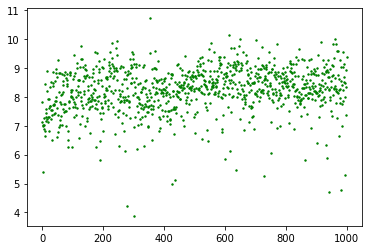

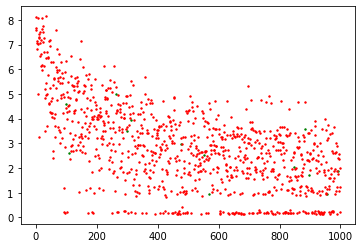

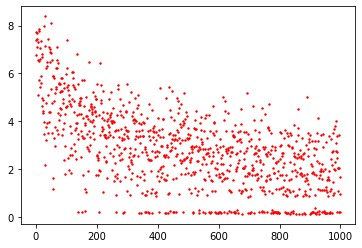

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

def strip_last(lookup_time):
    if lookup_time[-2:] == "ms":
        return lookup_time[:-2]
    elif lookup_time[-2:] == "µs":
        return float(lookup_time[:-2]) / 1000 

for k in range(25, 30):
    for hash_len in [4, 8, 12]:
        csv_file = f"src/benchmark/lookup_csv/lookup_{k}_{hash_len}.csv"
        
        df = pd.read_csv(csv_file)
        
        df["LookupTime(ms)"] = df["LookupTime(ms)"].apply(strip_last)
        df["LookupTime(ms)"] = df["LookupTime(ms)"].astype(float)
        
        found_true = df[df["IsExist"] == True]
        found_false = df[df["IsExist"] == False]
        print(found_false)

        
        fig, ax = plt.subplots()
        plt.scatter(found_true.index, found_true["LookupTime(ms)"], label=f'', s=2, color="green")
        plt.scatter(found_false.index, found_false["LookupTime(ms)"], label=f'', s=2, color="red")

        print(df["LookupTime(ms)"])
        
    break